# 无限大平板非稳态自然对流换热问题

初始化 Python 程序运行环境，导入所需的计算库、绘图库。

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [14, 7]

## 初始化题目给定参数

平板厚度 $$L = 0.03 m$$

导热系数 $$\lambda = 20 W/m \cdot K$$

密度乘以比热容 $$\rho c = 3.6 \times 10^6 J/m$$

平板初始温度 $$T_w = 300 ^{\circ}C$$

流体温度 $$T_{f2} = 20 ^{\circ}C$$

对流换热系数 $$h = 20 W/m^2 \cdot ^{\circ}C$$

In [3]:
L = 0.03 # m
lambda_ = 20 # W/m.K
rho_c = 3.6e6 # J/m
T_w = 300 # C
T_f2 = 20 # C
h = 20 # W/m^2.C

## 差分计算式导出

### 内部节点

内部节点导热偏微分方程

$$\rho c \Delta x \frac{\partial u}{\partial t} = - \lambda \frac{\partial u_i}{\partial x} - ( - \lambda \frac{\partial u_{i - 1}}{\partial x})$$

$$\rho c \frac{\partial u}{\partial t} = - \lambda \frac{\partial^2 u}{\partial x^2}$$

内部节点导热差分方程

$$\rho c \frac{u_i^{n + 1} - u_i^n}{\Delta t} = - \lambda \frac{\frac{u_i^n - u_{i + 1}^n}{\Delta x} - \frac{u_{i - 1}^n - u_i^n}{\Delta x}}{\Delta x}$$

$$\rho c \frac{u_i^{n + 1} - u_i^n}{\Delta t} = \lambda \frac{u_{i + 1}^n - 2 u_i^n + u_{i - 1}^n}{(\Delta x)^2}$$

内部节点差分计算式

$$u_i^{n + 1}= u_i^n - \frac{\Delta t}{\rho c} \times \lambda \frac{u_{i + 1}^n - 2 u_i^n + u_{i - 1}^n}{(\Delta x)^2}$$

### 边缘节点

边缘节点对流偏微分方程

$$\rho c \Delta x \frac{\partial u}{\partial t} = - h \Delta u + ( - \lambda \frac{\partial u_0}{\partial x})$$

边缘节点导热、对流差分方程

$$\rho c \frac{u_0^{n + 1} - u_0^n}{\Delta t} = - h \frac{u_0^n - T_{f2}}{\Delta x} - \lambda \frac{u_0^n - u_1^n}{(\Delta x)^2}$$

$$\rho c \frac{u_N^{n + 1} - u_N^n}{\Delta t} = - h \frac{u_N^n - T_{f2}}{\Delta x} - \lambda \frac{u_N^n - u_{N - 1}^n}{(\Delta x)^2}$$

边缘节点导热、对流差分计算式

$$u_0^{n + 1}= u_0^n - \frac{\Delta t}{\rho c} \times \left(h \frac{u_0^n - T_{f2}}{\Delta x} + \lambda \frac{u_0^n - u_1^n}{(\Delta x)^2}\right)$$

$$u_N^{n + 1}= u_N^n - \frac{\Delta t}{\rho c} \times \left(h \frac{u_N^n - T_{f2}}{\Delta x} + \lambda \frac{u_N^n - u_{N - 1}^n}{(\Delta x)^2}\right)$$

## 计算

### 设定计算参数

使用第一类网格，共分成 nx 个点

迭代 nt 次

每次间隔 dt 秒

总长平分成网格，每格 dx 长度

初始化温度场为 u 数组

初始化每个点的 x 坐标为 ux 数组

In [4]:
nx = 41
nt = 800
dt = .025
dx = L / (nx - 1)
u = T_w * np.ones(nx)
ux = L * np.linspace(0, 1, nx)

un 为当前时层的温度，u 为待计算的 n+1 时层的温度
每次迭代前，把 u 复制到 un，然后用 un 来计算 u

In [5]:
for n in range(nt):
    un = u.copy()
    i = 0
    u[i] = un[i] - dt / rho_c * (h * (un[i] - T_f2) / dx + lambda_ * (un[i] - un[i + 1]) / (dx * dx))
    for i in range(1, nx - 1):
        u[i] = un[i] + dt / rho_c * lambda_ * (un[i + 1] - 2 * un[i] + un[i - 1]) / (dx * dx)
    i = nx - 1
    u[i] = un[i] - dt / rho_c * (h * (un[i] - T_f2) / dx + lambda_ * (un[i] - un[i - 1]) / (dx * dx))

绘制当前温度（800 * 0.025s = 20s 时的温度）

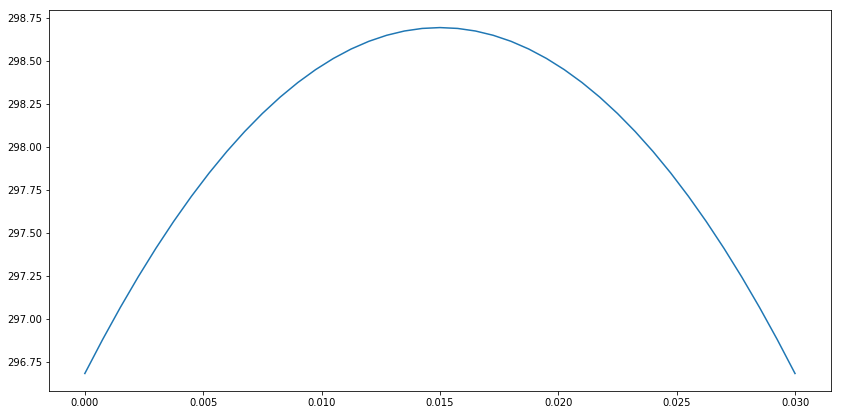

In [6]:
plt.plot(ux, u)

### 调节计算参数

调节步长和循环次数，并添加边缘和中心的温度随时间变化曲线，再加上温度近似解析解

$$u(t) = T_{f2} + (T_w - T_{f2}) \times e^{-\frac{h A}{\rho c \frac{v}{2}}t}$$

In [7]:
def calc(nx=41, nt=200000, dt=.05, ux_plot_lines=10):
    dx = L / (nx - 1)
    u = T_w * np.ones(nx)
    ux = L * np.linspace(0, 1, nx)
    u0t = np.zeros(nt)
    umt = np.zeros(nt)
    tx = np.multiply(dt, np.arange(nt))
    fig, (ux_plot, ut_plot) = plt.subplots(1, 2)
    ux_plot_interval = nt / ux_plot_lines
    ux_plot.plot(ux, u, label='0s')
    k = 0

    for n in range(nt):
        un = u.copy()
        i = 0
        u[i] = un[i] - dt / rho_c * (h * (un[i] - T_f2) / dx + lambda_ * (un[i] - un[i + 1]) / (dx * dx))
        for i in range(1, nx - 1):
            u[i] = un[i] + dt / rho_c * lambda_ * (un[i + 1] - 2 * un[i] + un[i - 1]) / (dx * dx)
        i = nx - 1
        u[i] = un[i] - dt / rho_c * (h * (un[i] - T_f2) / dx + lambda_ * (un[i] - un[i - 1]) / (dx * dx))
        if k > ux_plot_interval:
            ux_plot.plot(ux, u, label=str(int(n * dt)) + 's')
            k = 0
        else:
            k += 1
        u0t[n] = u[0]
        umt[n] = u[(nx + 1) // 2]
    ux_plot.plot(ux, u, label=str(int(nt * dt)) + 's')
    ux_plot.legend()

    ut_plot.plot(tx, u0t, label='u0(t)')
    ut_plot.plot(tx, umt, label='um(t)')
    ut_ana = T_f2 + (T_w - T_f2) * np.exp(-h / (rho_c * L / 2) * tx)
    ut_plot.plot(tx, ut_ana, label='u(t) analysis')
    ut_plot.legend()
    return u, u0t, umt, ut_ana, tx

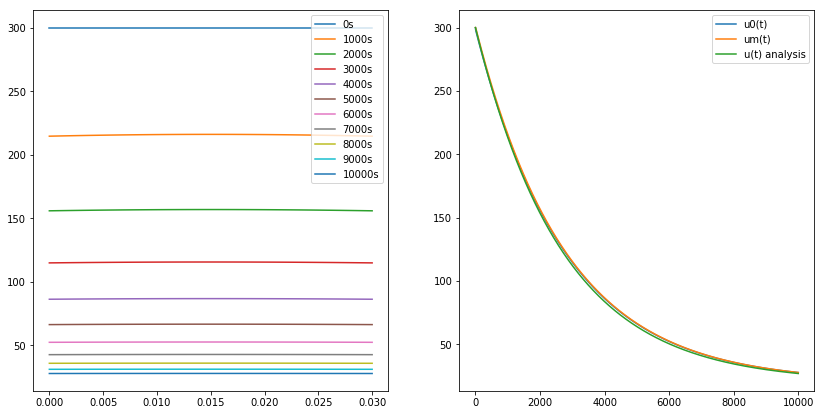

In [8]:
dt = .05
u, u0t, umt, ut_ana, tx = calc(dt=dt)

上图中，左侧的图为不同时间平板内部温度场，右图为平板边缘、平板中心的温度随时间变化曲线、以及一条近似问题的解析解曲线。

左图中，我们可以看出，平板内部的温度场基本上是均匀的，导热远远强于自然对流换热，中心温度只是略高。

我们可以看出，边缘温度的数值解与解析解符合的较好，中心温度变化略落后与边缘温度，由于解析解是按无限大均匀温度场的物体计算，所以中心温度会有一些差别。

## 继续探究

我们继续探究一下中心和边缘温差的变化曲线

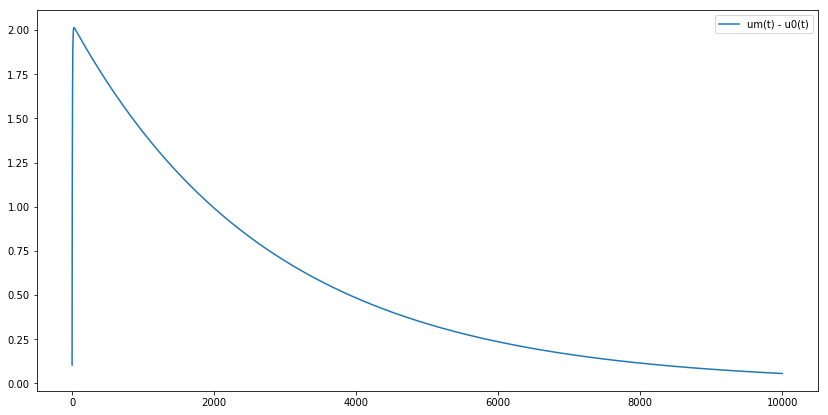

In [9]:
plt.plot(tx, umt - u0t, label='um(t) - u0(t)')
plt.legend()

可以看到，边缘最初的变化很快，在第一个点的位置就立刻达到了 0.1 摄氏度，并迅速增加到 2.0 摄氏度，然后这个温差会按近似指数形式衰减

In [10]:
u_diff = umt - u0t
u_diff_max_n = u_diff.argmax(axis=0)
u_diff_max_t = u_diff_max_n * dt
u_diff_max_t

27.0

可以算出，这个最大值的点出现在 27 秒的时候。我打算重新计算一下 27 * 2 = 54s 以内温度场的变化。

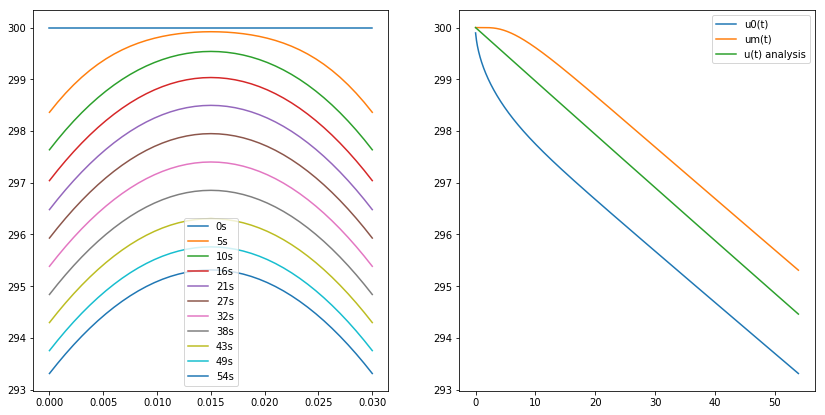

In [11]:
u, u0t, umt, ut_ana, tx = calc(nt=u_diff_max_n * 2)

重新计算之后我们会发现，中心变化明显落后于解析解，边缘温度明显领先于解析解，这也是符合预期的，这个平板是有厚度的，温度场是非均匀的。

## 总结

通过本次数值模拟实验，我掌握了数值模拟部分离散方法，学到了一些编程计算方法，最终成功得到了结果，“计算流体力学与传热学”这门课程使我懂得了不少知识，受益匪浅。

班级：

姓名：

学号：